In [1]:
import orjson
import matplotlib.pyplot as plt
from snsphd import viz
from snsphd.help import prinfo
import numpy as np
from IPython.display import JSON
from enum import Enum
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from qutip import *

from util import (
    TomoCounts,
    Bin,
    Phase,
    create_matrix_row,
    print_matrix,
    shiftedColorMap,
)


Colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)

from typing import List
from pydantic import BaseModel, validator, Field

In [2]:
from custom_model_dm import (
    PowerRamp,
    ValueIntegrateExtraData,
    ExtremumResults,
    pretty_print_model,
)

In [3]:
with open("../data/longer_scan_2/s_min_power_ramp.json", "rb") as f:
    data_min = orjson.loads(f.read())

with open("../data/longer_scan_2/s_d90_power_ramp.json", "rb") as f:
    data_90 = orjson.loads(f.read())

with open("../data/longer_scan_2/s_max_derived_power_ramp.json", "rb") as f:
    data_max_derived = orjson.loads(f.read())

In [5]:
ramp_min = PowerRamp(**data_min)
ramp_max = PowerRamp(**data_max_derived)
ramp_90 = PowerRamp(**data_90)

In [6]:
pretty_print_model(ramp_max, max_depth=4)

  -- 
 name: PowerRamp
   state :finished
   label :default_label
   results <list>
     0 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     1 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     2 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     3 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: Sim

In [7]:
from typing import Union, get_origin, get_args


def print_string_or_none(value: Union[str, None]):
    if get_origin(Union) == type(value) and str in get_args(Union):
        print(value)
    else:
        print("NaN")

In [8]:
from typing import Union, get_origin, get_args
from dataclasses import dataclass


@dataclass
class MyClass:
    name: str
    value: Union[str, None]

    def print_value(self):
        if get_origin(Union) == type(self.value) and str in get_args(Union):
            print(f"{self.name}: {self.value}")
        else:
            print(f"{self.name}: NaN")

In [9]:
pretty_print_model(ramp_min.results[3].results[2])

  -- 
 name: Extremum
   results -- 
     counts_list <list>
       0 :801
       1 :801
       2 :801
       3 :801
       4 :802
       5 :801
       6 :801
     times_list <list>
       0 :280.9057409763336
       1 :295.93887877464294
       2 :311.95584416389465
       3 :265.20647740364075
       4 :292.01120233535767
       5 :293.73412132263184
       6 :305.67842078208923
     direction_array <list>
     voltage_list <list>
       0 :2.54375
       1 :2.54
       2 :2.53625
       3 :2.5324999999999998
       4 :2.53625
       5 :2.54
       6 :2.54375
   integration_results <list>
     0 -- 
     name: ValueIntegrateExtraData
       label :default_label
       counts :801
       delta_time :280.9057409763336
       coincidences_hist_1 :...data...type: <class 'numpy.float64'>
       coincidences_hist_2 :...data...type: <class 'numpy.float64'>
       full_coinc_1 :...data...type: <class 'numpy.float64'>
       full_coinc_2 :...data...type: <class 'numpy.float64'>
       singles

In [10]:
# ramp_90.results[3]


class DMData(BaseModel):
    phase_90: List[ValueIntegrateExtraData]
    phase_min_res: ExtremumResults
    phase_min: List[ValueIntegrateExtraData]
    phase_max: List[ValueIntegrateExtraData]
    # phase_max_res: ExtremumResults


power_steps: List[DMData] = []
powers = []

for i in range(len(ramp_90.results) - 1):
    scan_step_90 = ramp_90.results[i]
    scan_step_min = ramp_min.results[i]
    scan_step_max = ramp_max.results[i]

    powers.append(scan_step_90.results[0].results.expected_amps)
    #    scan_step_min.results[0].result.expected_amps,
    #    scan_step_max.results[0].result.expected_amps])

    # you WILL be changing these when you switch to singleSet for the 90 and max phase settings
    int_results_90: List[ValueIntegrateExtraData] = scan_step_90.results[2].results
    int_results_min: List[ValueIntegrateExtraData] = scan_step_min.results[
        2
    ].integration_results
    int_results_min_res: ExtremumResults = scan_step_min.results[2].results
    int_results_max_res: ExtremumResults = scan_step_max.results[2].results

    int_results_max = scan_step_max.results[2].results

    power_steps.append(
        DMData(
            phase_90=int_results_90,
            phase_min=int_results_min,
            phase_max=int_results_max,
            phase_min_res=int_results_min_res,
        )
    )

140


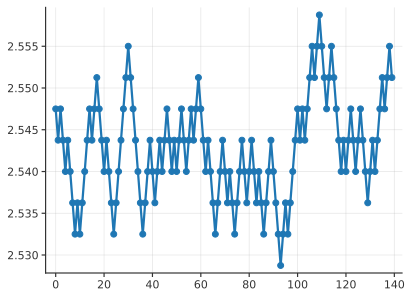

<Figure size 1600x1200 with 0 Axes>

In [11]:
voltages = []
counts = []
times = []

max_counts = []
max_times = []

singles_A = []
singles_B = []
coincidences = []

for power in power_steps:
    # print(power.phase_min_res.voltage_list)
    voltages.extend(power.phase_min_res.voltage_list)
    counts.append(power.phase_min_res.counts_list)
    times.append(power.phase_min_res.times_list)
    # max_counts.append(power.phase_max_res.counts_list)
    # max_times.append(power.phase_max_res.times_list)

    sect = power.phase_90[0]
    Sa = np.sum(sect.singles_hist_1) / sect.delta_time
    Sb = np.sum(sect.singles_hist_2) / sect.delta_time
    Cc = sect.total_coincidences / sect.delta_time

    singles_A.append(Sa)
    singles_B.append(Sb)
    coincidences.append(Cc)

plt.plot(voltages, "-o")
print(len(voltages))
plt.figure()

counts_avg = np.average(counts, axis=1)
counts_std = np.std(counts, axis=1)

times_avg = np.average(times, axis=1)
times_std = np.std(times, axis=1)

# max_counts_avg = np.average(max_counts, axis=1)
# max_times_avg = np.average(max_times, axis=1)

# MIN = counts_avg/times_avg
# MAX = max_counts_avg/max_times_avg

# plt.plot(counts_avg/times_avg, '-o')
# plt.yscale('log')

# plt.figure()
# plt.plot(1 - MIN/MAX)

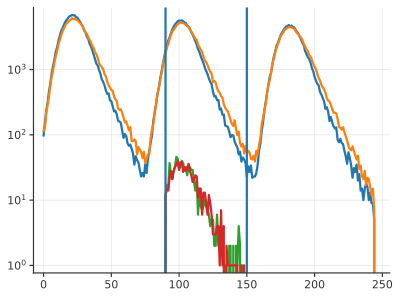

In [12]:
power_idx = 1
iter_idx = 0
hist1, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_1, bins=np.arange(250)
)
hist2, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_2, bins=np.arange(250)
)

hist1_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_1, bins=np.arange(250)
)
hist2_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_2, bins=np.arange(250)
)

plt.plot(bins[:-1], hist1)
plt.plot(bins[:-1], hist2)

plt.plot(bins[:-1], hist1_i)
plt.plot(bins[:-1], hist2_i)
plt.yscale("log")
plt.axvline(x=90)
plt.axvline(x=150)

In [28]:
# this takes a while


# idx = 5 # goes over the repeated integrations


class ArrayData(BaseModel):
    avg: np.ndarray # ultimately gets converted to np.ndarray, but 'list' keeps mypy happy
    std: np.ndarray

    @validator("avg", "std", pre=True)
    def to_numpy_float(cls, value) -> np.ndarray:
        return np.array(value, dtype=float)

    class Config:
        arbitrary_types_allowed = True


class TomoOutput(BaseModel):
    fidelities: ArrayData
    fidelities_sub: ArrayData
    rates: ArrayData
    log_negativities: ArrayData
    coherent_infos: ArrayData
    car_mu: ArrayData

class ThisPowerTomoOutput(BaseModel):
    this_power_tomos: list
    this_power_coherent_infos: list
    this_power_log_negativities: list
    this_power_fidelities: list
    this_power_fidelities_sub: list
    this_power_rates: list
    this_power_car_mu: list


def tomo_from_power_step(
    step: DMData,
    print_output: bool = False,
    bin_ranges: list[list[int]] = [[0, 80], [90, 150], [160, 240]],
) -> ThisPowerTomoOutput:
    """
    Takes a power step and returns the tomography results
    """
    this_power_coherent_infos = []
    this_power_log_negativities = []
    this_power_fidelities = []
    this_power_fidelities_sub = []
    this_power_rates = []
    this_power_tomos = []
    this_power_car_mu = []
    for idx in range(
        2, len(step.phase_max)
    ):  # the number of integrations in each power
        # ddic = step.phase_max[idx]

        tomo = TomoCounts()
        total_rate = (
            step.phase_90[idx].total_coincidences / step.phase_90[idx].delta_time
        )

        if print_output:
            print("total rate: ", total_rate)
            print("length: ", len(step.phase_90[idx].full_coinc_1))
            print("delta time: ", step.phase_90[idx].delta_time)


        singles_rate_A = np.sum(step.phase_min[idx].singles_hist_1)/step.phase_min[idx].delta_time
        singles_rate_B = np.sum(step.phase_min[idx].singles_hist_2)/step.phase_min[idx].delta_time
        print("singles rate A: ", singles_rate_A)
        print("singles rate B: ", singles_rate_B)

        ratio_of_singles_A_in_center_bin = np.sum(step.phase_min[idx].singles_hist_1[90:150])/np.sum(step.phase_min[idx].singles_hist_1)
        ratio_of_singles_B_in_center_bin = np.sum(step.phase_min[idx].singles_hist_2[90:150])/np.sum(step.phase_min[idx].singles_hist_2)
        print("ratio of singles A in center bin: ", ratio_of_singles_A_in_center_bin)
        print("ratio of singles B in center bin: ", ratio_of_singles_B_in_center_bin)

        singles_center_drc_A_rate = ratio_of_singles_A_in_center_bin * singles_rate_A * 1 # * (1 - 0.393) # 0.393 is the geometric factor
        singles_center_drc_B_rate = ratio_of_singles_B_in_center_bin * singles_rate_B * 1 # * (1 - 0.393) # 0.393 is the geometric factor
        # print("singles center drc A rate: ", singles_center_drc_A_rate)
        # print("singles center drc B rate: ", singles_center_drc_B_rate)

        ratio_of_laser_pulses_with_dcr_A = singles_center_drc_A_rate/4e9
        ratio_of_laser_pulses_with_dcr_B = singles_center_drc_B_rate/4e9

        ratio_of_laser_pulses_with_drc_coincidence = ratio_of_laser_pulses_with_dcr_A * ratio_of_laser_pulses_with_dcr_B

        rate_of_drc_coincidences = ratio_of_laser_pulses_with_drc_coincidence*4e9
        # print("     rate of drc coincidences: ", rate_of_drc_coincidences)
        

        # print("singles rate A: ", singles_rate_A)
        # print("singles rate B: ", singles_rate_B)

        tomo.fill(
            Phase.DD,
            step.phase_max[idx].full_coinc_1,
            step.phase_max[idx].full_coinc_2,
            step.phase_max[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.DR,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RD,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RR,
            step.phase_min[idx].full_coinc_1,
            step.phase_min[idx].full_coinc_2,
            step.phase_min[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.calculate_density_matrix()

        # fidelity = (step.phase_min[idx].counts / step.phase_min[idx].delta_time) / (
        #     step.phase_max[idx].counts / step.phase_max[idx].delta_time
        # )
        tomo.rate_drc_coinc = rate_of_drc_coincidences

        fidelity_sub = tomo.calculate_fidelity(dcr_subtraction=True)
        fidelity = tomo.calculate_fidelity(dcr_subtraction=False)

        print("rate in minimized center bin: ", tomo.rr[-1])

        log_negativity = tomo.calculate_log_negativity(tomo.rho)
        coherent_info = tomo.calculate_coherent_information(tomo.rho)

        this_power_log_negativities.append(log_negativity)
        this_power_coherent_infos.append(coherent_info)


        this_power_fidelities.append(fidelity)
        this_power_fidelities_sub.append(fidelity_sub)
        this_power_rates.append(total_rate)
        this_power_tomos.append(tomo)
        this_power_car_mu.append(tomo.calculate_car_mu())
        print("car mu: ", tomo.calculate_car_mu())

    return ThisPowerTomoOutput(this_power_tomos=this_power_tomos,
                        this_power_coherent_infos=this_power_coherent_infos,
                        this_power_log_negativities=this_power_log_negativities,
                        this_power_fidelities=this_power_fidelities,
                        this_power_fidelities_sub=this_power_fidelities_sub,
                        this_power_rates=this_power_rates,
                        this_power_car_mu=this_power_car_mu)


def do_tomography_and_export_metrics(
    power_steps: List[DMData], print_output=False
) -> tuple[TomoOutput, list[list[TomoCounts]]]:
    coherent_infos_avg = []
    coherent_infos_std = []

    log_negativities_avg = []
    log_negativities_std = []

    fidelities_avg = []
    fidelities_std = []

    fidelities_sub_avg = []
    fidelities_sub_std = []

    car_mu_avg = []
    car_mu_std = []

    rates_avg = []
    rates_std = []
    tomos = []

    for i in range(len(power_steps)):
        step: DMData = power_steps[i]
        t = tomo_from_power_step(step, print_output)

        # print(t)
        coherent_infos_avg.append(np.average(t.this_power_coherent_infos))
        coherent_infos_std.append(np.std(t.this_power_coherent_infos))
        log_negativities_avg.append(np.average(t.this_power_log_negativities))
        log_negativities_std.append(np.std(t.this_power_log_negativities))

        fidelities_avg.append(np.average(t.this_power_fidelities))
        fidelities_std.append(np.std(t.this_power_fidelities))

        fidelities_sub_avg.append(np.average(t.this_power_fidelities_sub))
        fidelities_sub_std.append(np.std(t.this_power_fidelities_sub))

        # prinfo(fidelities_avg)
        # prinfo(fidelities_std)
        rates_avg.append(np.average(t.this_power_rates))
        rates_std.append(np.std(t.this_power_rates))
        car_mu_avg.append(np.average(t.this_power_car_mu))
        car_mu_std.append(np.std(t.this_power_car_mu))
        tomos.append(t.this_power_tomos)

    output = TomoOutput(
        fidelities=ArrayData(avg=fidelities_avg, std=fidelities_std),
        fidelities_sub=ArrayData(avg=fidelities_sub_avg, std=fidelities_sub_std),
        rates=ArrayData(avg=rates_avg, std=rates_std),
        log_negativities=ArrayData(avg=log_negativities_avg, std=log_negativities_std),
        coherent_infos=ArrayData(avg=coherent_infos_avg, std=coherent_infos_std),
        car_mu=ArrayData(avg=car_mu_avg, std=car_mu_std),
    )

    return output, tomos


In [29]:
tomography_result, tomos = do_tomography_and_export_metrics(
    power_steps, print_output=True
)

total rate:  395.8917867545204
length:  90311
delta time:  228.1204183101654
singles rate A:  13285.345624612
singles rate B:  23135.21524054873
ratio of singles A in center bin:  0.42546528621646945
ratio of singles B in center bin:  0.3926004336737298
rate in minimized center bin:  0.7248
car mu:  0.0038568202455419556
total rate:  397.58016033667263
length:  90754
delta time:  228.26591730117798
singles rate A:  13247.916183431147
singles rate B:  23131.684988428853
ratio of singles A in center bin:  0.42333547894885926
ratio of singles B in center bin:  0.3915217306333822
rate in minimized center bin:  0.6227
car mu:  0.003578698922631718
total rate:  406.1147071992016
length:  89361
delta time:  220.03881764411926
singles rate A:  13074.980304767041
singles rate B:  22912.7420611858
ratio of singles A in center bin:  0.4231495778729006
ratio of singles B in center bin:  0.39270093329843836
rate in minimized center bin:  0.6532
car mu:  0.00348683681243559
total rate:  408.83434391

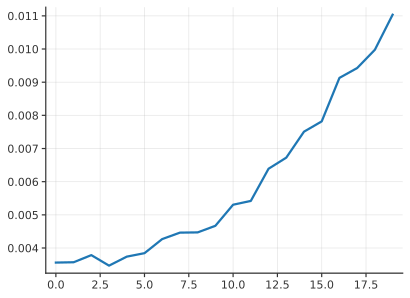

In [15]:
plt.plot(tomography_result.car_mu.avg)

[[0, 80], [80, 160], [160, 240]]
singles rate A:  711394.4219579032
singles rate B:  966455.9772649781
ratio of singles A in center bin:  0.4863687796817271
ratio of singles B in center bin:  0.4804355751557584
rate in minimized center bin:  125.9696
car mu:  0.010555250298301346
singles rate A:  712896.2577638918
singles rate B:  967459.1105900521
ratio of singles A in center bin:  0.4863195540269873
ratio of singles B in center bin:  0.4807453691683226
rate in minimized center bin:  126.7327
car mu:  0.01053707202557804
singles rate A:  714606.5867457718
singles rate B:  970754.4178092708
ratio of singles A in center bin:  0.4864536149387635
ratio of singles B in center bin:  0.4803451569680445
rate in minimized center bin:  122.6155
car mu:  0.011190041134580338
singles rate A:  717559.2512250362
singles rate B:  974868.4582662828
ratio of singles A in center bin:  0.48621662308881364
ratio of singles B in center bin:  0.4805408858774966
rate in minimized center bin:  136.5926
car m

c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 3400.
  warnings.warn(errors[info][0], RuntimeWarning)


rate in minimized center bin:  78.1332
car mu:  0.006449991271852138
singles rate A:  722228.7076574478
singles rate B:  980161.3821605424
ratio of singles A in center bin:  0.4850660438540284
ratio of singles B in center bin:  0.4803792088276878
rate in minimized center bin:  69.1432
car mu:  0.007611509483038699
[99.18899576725774, 99.15747440510685, 99.19497889444709, 99.05426340037415, 99.17854832493333]
[[0, 56], [104, 136], [184, 240]]
singles rate A:  711394.4219579032
singles rate B:  966455.9772649781
ratio of singles A in center bin:  0.4863687796817271
ratio of singles B in center bin:  0.4804355751557584
rate in minimized center bin:  47.2851
car mu:  0.006468548835908852
singles rate A:  712896.2577638918
singles rate B:  967459.1105900521
ratio of singles A in center bin:  0.4863195540269873
ratio of singles B in center bin:  0.4807453691683226
rate in minimized center bin:  47.3354
car mu:  0.005285375513866395
singles rate A:  714606.5867457718
singles rate B:  970754.4

<ErrorbarContainer object of 3 artists>

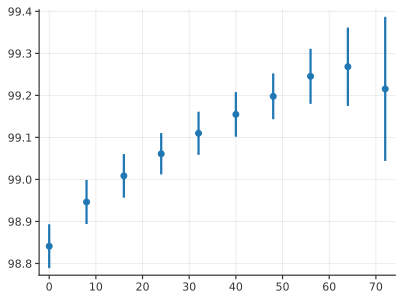

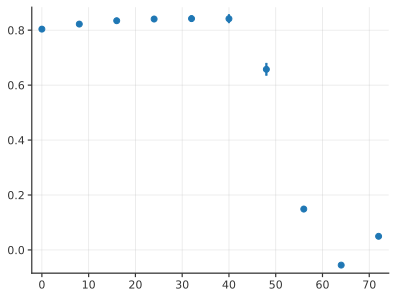

In [43]:


fidelities_avg = []
fidelities_std = []
guard_sizes = []
coherent_infos_avg = []
coherent_infos_std = []
for x in range(0, 40, 4):
    guard_sizes.append(2*x)
    bin_range = [[0, 80-x], [80+x, 160-x], [160+x, 240]]
    print(bin_range)
    t = tomo_from_power_step(power_steps[-1], print_output=False, bin_ranges = bin_range)
    fidelities_avg.append(np.average(t.this_power_fidelities))
    fidelities_std.append(np.std(t.this_power_fidelities))
    coherent_infos_avg.append(np.average(t.this_power_coherent_infos))
    coherent_infos_std.append(np.std(t.this_power_coherent_infos))
    print(t.this_power_fidelities)

# plt.plot(guard_sizes, fidelities_avg)
plt.errorbar(guard_sizes, fidelities_avg, yerr=fidelities_std, fmt='o')
plt.figure()
plt.errorbar(guard_sizes, coherent_infos_avg, yerr=coherent_infos_std, fmt='o')


In [16]:
tomo = tomos[-1][-1]

print(tomo)
tomo.calculate_coherent_information(tomo.rho)
tomo.calculate_fidelity()

phase		|dd>		|dr>		|rd>		|rr>
ee: 		3493.2001	3941.931	3941.931	4105.6085	
el: 		37.6525		54.2044		54.2044		54.3268		
ed: 		3055.6883	0.0		3280.2333	0.0		
er: 		0.0		3280.2333	0.0		3457.2913	
le: 		20.1521		27.1022		27.1022		29.4993		
ll: 		2149.9064	2412.3857	2412.3857	2476.7399	
ld: 		2534.3864	0.0		2726.0794	0.0		
lr: 		0.0		2726.0794	0.0		2819.5191	
de: 		2846.213	3108.1054	0.0		0.0		
dl: 		2734.3161	2905.992	0.0		0.0		
dd: 		10774.9871	0.0		0.0		0.0		
dr: 		0.0		5774.7906	0.0		0.0		
re: 		0.0		0.0		3108.1054	3284.4334	
rl: 		0.0		0.0		2905.992	3023.7451	
rd: 		0.0		0.0		5774.7906	0.0		
rr: 		0.0		0.0		0.0		108.1196	



98.99656863626315

In [17]:
geometric_factor = (
    0.393  # a result of the JSI modelling analysis: gamma_geo = 0.393 +/- 0.012
)

mus = (
    np.array(singles_A)
    * np.array(singles_B)
    * geometric_factor
    / (np.array(coincidences) * 4e9)
)

In [18]:
@dataclass
class Line:
    slope: float
    intercept: float

Line(slope=2.8808297571539874, intercept=0.0030833806068345884)


Text(0, 0.5, 'mu defined from CAR')

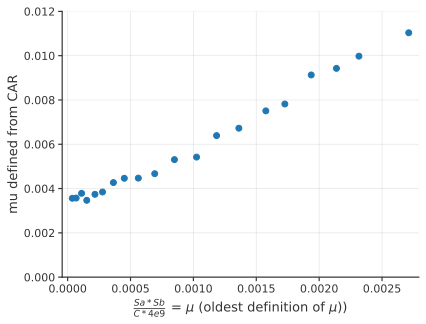

In [19]:
plt.plot(mus, tomography_result.car_mu.avg, "o")

coeffs = np.polyfit(mus, tomography_result.car_mu.avg, 1)
car_mu_line = Line(coeffs[0], coeffs[1])
print(car_mu_line)

car_mus = mus*car_mu_line.slope + car_mu_line.intercept
# plt.plot(mus, car_mus, label="car mu line")
plt.ylim(0,0.012)
plt.xlabel(r"$\frac{Sa*Sb}{C*4e9}$ = $\mu$ (oldest definition of $\mu$))")
plt.ylabel("mu defined from CAR")

In [22]:
# mus = car_mus

In [20]:
tomography_result.fidelities_sub.avg

array([99.6445116 , 99.64696888, 99.65000056, 99.65497039, 99.63987808,
       99.61605189, 99.65731911, 99.60688777, 99.61758341, 99.5686371 ,
       99.5545887 , 99.5514324 , 99.55352533, 99.49604587, 99.50378465,
       99.45934072, 99.42815588, 99.47711208, 99.39022089, 99.29967784])

In [21]:
tomography_result.fidelities.std

array([0.02533028, 0.0122215 , 0.01591554, 0.02189507, 0.02330211,
       0.00900767, 0.00606336, 0.01292106, 0.01701776, 0.02002908,
       0.0270281 , 0.02760785, 0.02890005, 0.02380884, 0.02291791,
       0.03627548, 0.04202096, 0.03028539, 0.0273297 , 0.04993742])

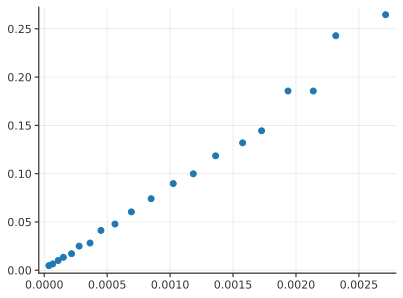

In [22]:
plt.plot(mus, tomography_result.fidelities_sub.avg - tomography_result.fidelities.avg, "o")

[1.2, 2.32, 2.83, 3.25, 3.65, 3.97]


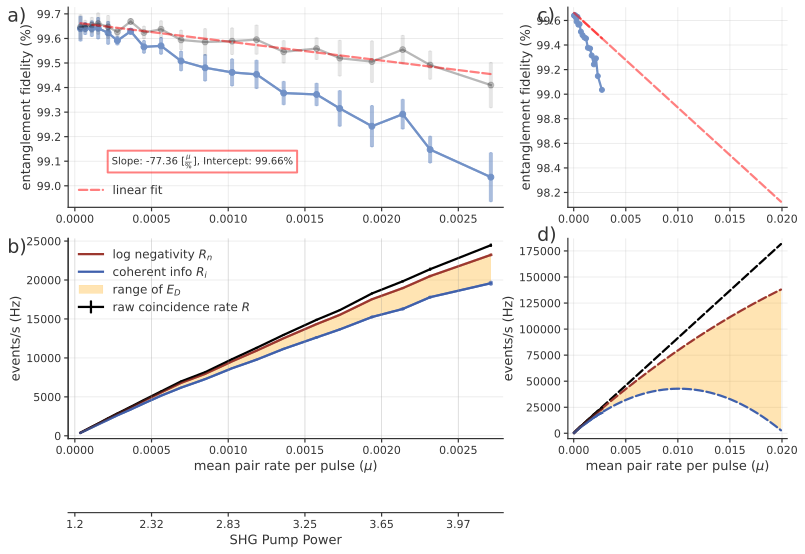

In [30]:
viz.update_colors(dark=False)

from scipy import interpolate
from snsphd.layout import bisect





fig = plt.figure(figsize=(10, 6))
divider_width = 0.09
master_bottom, master_top = bisect(
    [0, 0, 1, 1],
    direction="horiz",
    offset=0.5,
    spacing=divider_width * 0.8,
    absolute_spacing=True,
)


top_left, top_right = bisect(
    master_top,
    direction="vert",
    offset=0.65,
    spacing=divider_width,
    absolute_spacing=True,
)
bottom_left, bottom_right = bisect(
    master_bottom,
    direction="vert",
    offset=0.65,
    spacing=divider_width,
    absolute_spacing=True,
)

fidelities = fig.add_axes(top_left)
rates = fig.add_axes(bottom_left)
extrapolate_fidelities = fig.add_axes(top_right)
extrapolate_rates = fig.add_axes(bottom_right)


powers = np.array(powers)

# geometric_factor = (
#     1  # a result of the JSI modelling analysis: gamma_geo = 0.393 +/- 0.012
# )

# mus = (
#     np.array(singles_A)
#     * np.array(singles_B)
#     * geometric_factor
#     / (np.array(coincidences) * 4e9)
# )


def comb(set1, set2):
    return np.sqrt(set1**2 + set2**2)


def plot_fidelities(ax, mus, res: TomoOutput, zoomed_out: bool = False) -> Line:
    y = res.fidelities.avg
    if zoomed_out:
        ax.plot(mus, y, "-o", color=Colors["blue"], markersize=5)

    else:
        ax.errorbar(
            mus,
            res.fidelities.avg,
            yerr=2 * res.fidelities.std,
            elinewidth=4,
            alpha=0.6,
            color=Colors["blue"],
        )
        ax.plot(mus, y, "-o", color=Colors["blue"])

        ax.errorbar(
            mus,
            res.fidelities_sub.avg,
            yerr=2 * res.fidelities_sub.std,
            elinewidth=4,
            alpha=0.1,
            color='k',
        )
        ax.plot(mus, res.fidelities_sub.avg, "-o", color='k', alpha=0.2)



    # coeffs = np.polyfit(mus, y, 1)
    coeffs = np.polyfit(mus, res.fidelities_sub.avg, 1)
    fidelity_line = Line(coeffs[0], coeffs[1])
    ax.plot(
        mus,
        fidelity_line.slope * mus + fidelity_line.intercept,
        color="red",
        linestyle="--",
        label="linear fit",
        alpha=0.5,
    )

    ax.set_ylabel("entanglement fidelity (%)")

    return fidelity_line


def plot_rates(ax, mus, res: TomoOutput, line_style="-") -> tuple[Line, Line, Line]:
    ax.errorbar(
        mus,
        res.rates.avg,
        yerr=res.rates.std,
        label=r"raw coincidence rate $R$",
        color="k",
        # ls="--",
    )

    ## rates fit line
    coeffs_rates = np.polyfit(mus, res.rates.avg, 1)
    rates_line = Line(coeffs_rates[0], coeffs_rates[1])

    ## coherent info fit line
    coeffs_coh_info = np.polyfit(mus, res.coherent_infos.avg, 1)
    coh_info_line = Line(coeffs_coh_info[0], coeffs_coh_info[1])

    ## log negativity fit line
    coeffs_log_neg = np.polyfit(mus, res.log_negativities.avg, 1)
    log_neg_line = Line(coeffs_log_neg[0], coeffs_log_neg[1])

    log_negativity_line = res.rates.avg * res.log_negativities.avg
    coherent_info_line = res.rates.avg * res.coherent_infos.avg
    ax.plot(
        mus,
        res.rates.avg * res.log_negativities.avg,
        label=r"log negativity $R_n$",
        color=Colors["dark_red"],
        alpha=1,
        linestyle=line_style,
    )
    ax.plot(
        mus,
        res.rates.avg * res.coherent_infos.avg,
        label=r"coherent info $R_i$",
        color=Colors["dark_blue"],
        alpha=1,
        linestyle=line_style,
    )
    ax.errorbar(
        mus,
        res.rates.avg * res.log_negativities.avg,
        yerr=comb(res.rates.std, res.log_negativities.std),
        elinewidth=4,
        color=Colors["dark_red"],
        alpha=0.4,
        linestyle=line_style,
    )

    ax.fill_between(
        mus,
        log_negativity_line,
        coherent_info_line,
        alpha=0.3,
        color="orange",
        label=r"range of $E_D$",
    )
    ax.errorbar(
        mus,
        res.rates.avg * res.coherent_infos.avg,
        yerr=comb(
            res.rates.std * res.coherent_infos.avg,
            res.rates.avg * res.coherent_infos.std,
        ),
        elinewidth=4,
        color=Colors["dark_blue"],
        alpha=0.7,
        linestyle=line_style,
    )

    ax.set_xlabel(r"mean pair rate per pulse ($\mu$)")
    ax.set_ylabel(r"events/s (Hz)")

    return log_neg_line, coh_info_line, rates_line


def plot_extrapolated_fidelities(ax, res: TomoOutput, fidelity_line: Line):
    mus_long = np.arange(1, 200) / 10000
    ax.plot(
        mus_long,
        fidelity_line.slope * mus_long + fidelity_line.intercept,
        color="red",
        linestyle="--",
        label="linear fit",
        alpha=0.5,
    )
    plot_fidelities(ax, mus, res, zoomed_out=True)


def plot_extrapolated_rates(
    ax, res: TomoOutput, rates_line: Line, log_neg_line: Line, coh_info_line: Line
):
    mus_long = np.arange(1, 200) / 10000

    # raw rates extrapolation
    ax.plot(
        mus_long,
        rates_line.slope * mus_long + rates_line.intercept,
        color="black",
        linestyle="--",
        label="linear fit",
    )

    # coherent info extrapolation

    coh_info_ln = (coh_info_line.slope * mus_long + coh_info_line.intercept) * (
        rates_line.slope * mus_long + rates_line.intercept
    )
    ax.plot(
        mus_long,
        coh_info_ln,
        color=Colors["dark_blue"],
        linestyle="--",
        label="linear fit",
    )

    # log negativity extrapolation
    log_neg_ln = (log_neg_line.slope * mus_long + log_neg_line.intercept) * (
        rates_line.slope * mus_long + rates_line.intercept
    )
    ax.plot(
        mus_long,
        log_neg_ln,
        color=Colors["dark_red"],
        linestyle="--",
        label="linear fit",
    )

    ax.fill_between(
        mus_long,
        log_neg_ln,
        coh_info_ln,
        alpha=0.3,
        color="orange",
        label=r"range of $E_D$",
    )

    plot_rates(ax, mus, res)


fidelity_line = plot_fidelities(fidelities, mus, tomography_result)
log_neg_line, coh_info_line, rates_line = plot_rates(rates, mus, tomography_result)

plot_extrapolated_fidelities(extrapolate_fidelities, tomography_result, fidelity_line)
plot_extrapolated_rates(
    extrapolate_rates, tomography_result, rates_line, log_neg_line, coh_info_line
)


# ax[0].set_xscale('log')
# ax[1].set_xscale('log')


def tick_function(thing):
    number = np.interp(thing, mus, powers)
    return number


fid_legend = fidelities.legend(loc="lower left", ncols=1, fancybox=False, frameon=False)
fid_legend.get_frame().set_facecolor("none")

rates_legend = rates.legend(loc="upper left", ncols=1, fancybox=False, frameon=False)
rates_legend.get_frame().set_facecolor("none")

# letter lables
fidelities.text(-0.14, 1, "a)", transform=fidelities.transAxes, fontsize=19, va="top")
rates.text(-0.14, 1, "b)", transform=rates.transAxes, fontsize=19, va="top")
extrapolate_fidelities.text(
    -0.14, 1, "c)", transform=extrapolate_fidelities.transAxes, fontsize=19, va="top"
)
extrapolate_rates.text(
    -0.14, 1.06, "d)", transform=extrapolate_rates.transAxes, fontsize=19, va="top"
)


# rates.set_xlim(0,.010)
ax2 = rates.twiny()
ax2.set_xlim(rates.get_xlim())
new_tick_locations = np.arange(mus[-1] * 2000) / 2000
ax2.set_xticks(new_tick_locations)
# rates.spines['bottom'].set_color('red') ############### here you need to fix the mu

power_labels = tick_function(new_tick_locations)
power_labels = [round(label, 2) for label in power_labels]
print(power_labels)
ax2.set_xticklabels(power_labels)


# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.37))


ax2.set_xlabel(r"SHG Pump Power")


fidelities.text(
    0.1,
    1.37,
    rf"Slope: {fidelity_line.slope:.2f} ${{[\frac{{\mu}}{{\%}}]}}$, Intercept: {fidelity_line.intercept:.2f}%",
    transform=plt.gca().transAxes,
    bbox=dict(
        facecolor="white",
        alpha=0.5,
        edgecolor="red",
        linewidth=2,
    ),
)


# You need to recaculate coincidence rate to take into account the ignored areas!!!
plt.savefig("shg_scan.pdf")
plt.savefig("shg_scan.svg")
plt.savefig("shg_scan.jpg")

There are a few different 'limits' to count rate that may be important, depending on the application.

1. Limited by coherent information (advanced network)
2. Limited by log negativity (advanced network)
3. Limited by quantum bit error rate (can I easily calculate it?)
4. Limited by detector count rate?

You need to figure out the sequence of these.

Okay, I'm going to go to lab and I'm going to test the max count rate.
No, you're only going to do that after Sam gets back. For now, you're going
to continue reading Gregor's paper so that you stay in the office in case
Sam gets back.


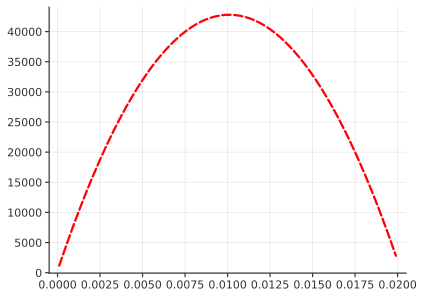

In [ ]:
def quadratic_coherent_info(mu):
    return (slope_ln * mu + intercept_ln) * (slope_rates * mu + intercept_rates)


mu_x = np.arange(1, 200) / 10000
plt.plot(
    mu_x,
    quadratic_coherent_info(mu_x),
    color="red",
    linestyle="--",
    label="quadratic fit",
)

Okay so the fit the the coherent infos rates line is quadratic, because it's the product of two things (count rate and coherent info) that both appear to vary linearly with mu. Therefore, 'coherent info rates' line has a maximum at about $\mu = 0.01$. We might just use this to define the maximum throughput per channel. At $\mu=0.01$, fidelity is expected to be (0.01)*-212.56 + 99.67% = 97.54%. Then what count rate would be be expecting? Well coincidence rate would be about 4 times higher, and coincidence rate scales linearly with \mu in this regime. So you can expect around ~(70 Kcoincs/s*4)\*4 ~ 1.12 Mcoincidences per second. Raw detector count rates would scale linearly as well


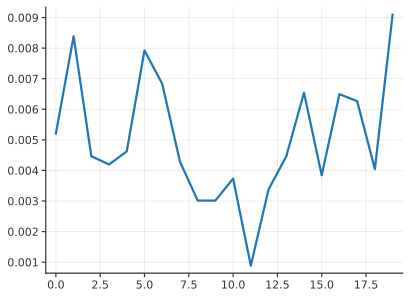

In [ ]:
plt.plot(coherent_infos_std)

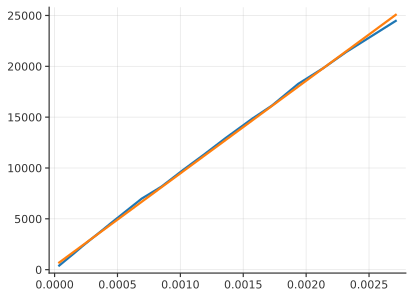

In [ ]:
plt.plot(mus, rates_avg)
coeffs_rates = np.polyfit(mus, rates_avg, 1)
slope_rates = coeffs_rates[0]
intercept_rates = coeffs_rates[1]
plt.plot(mus, slope_rates * mus + intercept_rates)

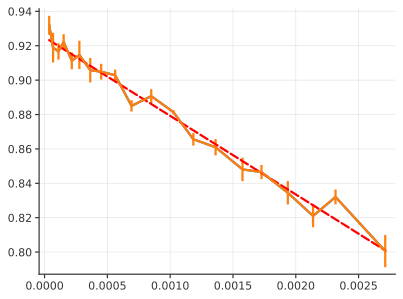

In [ ]:
plt.plot(mus, coherent_infos_avg)

plt.errorbar(mus, coherent_infos_avg, yerr=coherent_infos_std)
coeffs_ln = np.polyfit(mus, coherent_infos_avg, 1)
slope_ln = coeffs_ln[0]
intercept_ln = coeffs_ln[1]
plt.plot(
    mus, slope_ln * mus + intercept_ln, color="red", linestyle="--", label="linear fit"
)

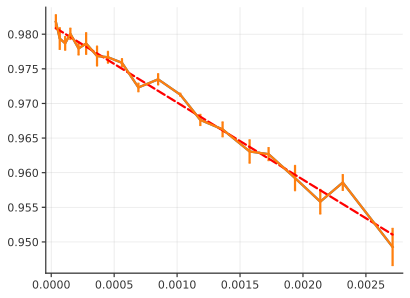

In [ ]:
plt.plot(mus, log_negativities_avg)

plt.errorbar(mus, log_negativities_avg, yerr=log_negativities_std)
coeffs_ln = np.polyfit(mus, log_negativities_avg, 1)
slope_ln = coeffs_ln[0]
intercept_ln = coeffs_ln[1]
plt.plot(
    mus, slope_ln * mus + intercept_ln, color="red", linestyle="--", label="linear fit"
)

In [ ]:
np.arange(mus[-1] * 5000) / 5000

array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026])

In [ ]:
coherent_infos_avg

array([0.93191286, 0.91892666, 0.91669026, 0.92220325, 0.91120481,
       0.91468854, 0.90575006, 0.90492058, 0.90284674, 0.88503261,
       0.89068627, 0.8814542 , 0.86560704, 0.86096327, 0.84808455,
       0.84651116, 0.83447668, 0.82102633, 0.83205359, 0.80058857])

In [ ]:
print(tomo)

phase		|dd>		|dr>		|rd>		|rr>
ee: 		3493.2		3941.93		3941.93		4105.61		
el: 		37.65		54.2		54.2		54.33		
ed: 		3055.69		0.0		3280.23		0.0		
er: 		0.0		3280.23		0.0		3457.29		
le: 		20.15		27.1		27.1		29.5		
ll: 		2149.91		2412.39		2412.39		2476.74		
ld: 		2534.39		0.0		2726.08		0.0		
lr: 		0.0		2726.08		0.0		2819.52		
de: 		2846.21		3108.11		0.0		0.0		
dl: 		2734.32		2905.99		0.0		0.0		
dd: 		10774.99	0.0		0.0		0.0		
dr: 		0.0		5774.79		0.0		0.0		
re: 		0.0		0.0		3108.11		3284.43		
rl: 		0.0		0.0		2905.99		3023.75		
rd: 		0.0		0.0		5774.79		0.0		
rr: 		0.0		0.0		0.0		108.12		



In [ ]:
power_idx = 19
iter_idx = 0

sect = power_steps[power_idx].phase_90[iter_idx]
Sa = np.sum(sect.singles_hist_1) / sect.delta_time
Sb = np.sum(sect.singles_hist_2) / sect.delta_time
Cc = sect.total_coincidences / sect.delta_time

In [ ]:
total_singles = (Sa + Sb) * 2
total_coincidences = Cc * 4

In [ ]:
col1 = [
    2.5,
    2.505,
    2.51,
    2.515,
    2.52,
    2.525,
    2.53,
    2.535,
    2.54,
    2.545,
    2.55,
    2.555,
    2.56,
    2.565,
]
col2 = [
    4.8,
    3.943,
    3.864,
    3.088,
    2.299,
    2.065,
    2.099,
    1.989,
    1.821,
    2.077,
    2.31,
    2.478,
    3.031,
    3.244,
]

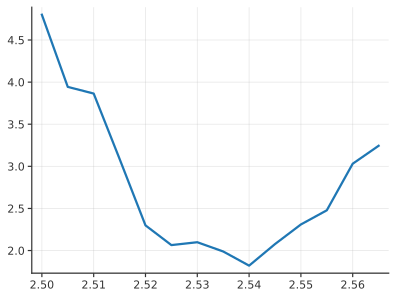

In [ ]:
plt.plot(col1, col2)

In [ ]:
np.average(
    [
        0.899,
        0.666,
        0.566,
        0.699,
        0.7,
        0.766,
        0.533,
        0.799,
        0.733,
        0.867,
        1.0,
        0.566,
        0.633,
        0.865,
        0.833,
        1.132,
        1.032,
        0.732,
        0.998,
        0.766,
        0.965,
        0.633,
    ]
)

0.7901363636363636